<a href="https://colab.research.google.com/github/balezz/cv_course_fa_mag/blob/main/CodeLab_3_ConvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CodeLab 3 - Реализация сверточной нейронной сети LeNet на Keras


В этом задании вам предстоит:

- изучить API Keras для создания и обучения нейросети (классификатора изображений);  
- подобрать архитектуру сети и гиперпараметры для получения accuracy > 0.8

In [1]:
import time
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

2026-01-30 07:29:20.285099: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-30 07:29:20.292133: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-30 07:29:20.539913: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-30 07:29:21.596977: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation or

## Загрузка датасета CIFAR-10 и нормализация данных

In [14]:
# Очистим значения переменных, чтобы избежать проблем с излишним потреблением памяти
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)

# Проверим размер входных и выходных векторов.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.


/home/andrej/miniconda3/lib/python3.13/site-packages/keras/src/datasets/cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


In [17]:
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

In [3]:
# Для сверточных сетей оставляем shape=(32,32,3), изменяем только формат данных uint8 -> fp64
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.flatten()
y_test = y_test.flatten()
# Проверим размер полученных данных
print('Training data shape: ', X_train.shape)
print('Test data shape: ', X_test.shape)
print('Training label shape: ', y_train.shape)
print('Test label shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Test data shape:  (10000, 32, 32, 3)
Training label shape:  (50000,)
Test label shape:  (10000,)


In [4]:
# Разделим данные на выборки train, val, test

num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 16

# Для валидации используем подвыборку train
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# На остальных данных из train будем тренировать модель
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# Чтобы ускорить разработку, создадим также небольшую dev выборку 
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# Для тестирования используем оригинальную выборку test
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


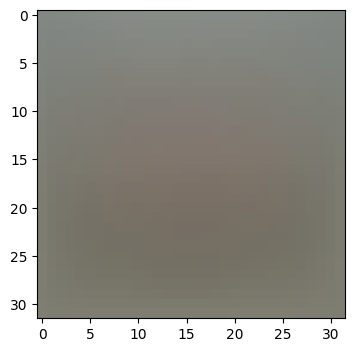

(49000, 32, 32, 3) (1000, 32, 32, 3) (1000, 32, 32, 3) (16, 32, 32, 3)


In [5]:
# Нормализуем значения яркости пикселей 
mean_image = np.mean(X_train, axis=0)

# визуализируем среднюю яркость
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()

# Вычтем средние значения яркости
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image


print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## LeNet architecture

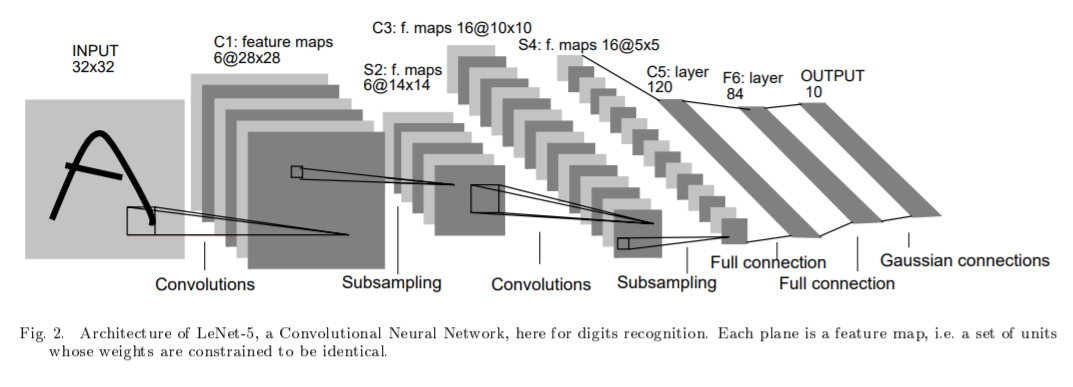

In [6]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models, layers

In [7]:
# Create LeNet instance
IMAGE_SHAPE = (32, 32, 3)
NUM_CLASSES = 10

lenet = models.Sequential()
lenet.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', 
                        input_shape=IMAGE_SHAPE, padding="same"))
lenet.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
lenet.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
lenet.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
lenet.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
lenet.add(layers.Flatten())
lenet.add(layers.Dense(84, activation='tanh'))
lenet.add(layers.Dense(NUM_CLASSES, activation='softmax'))    
lenet.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD')

/home/andrej/miniconda3/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1769747366.456156 1672140 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1769747366.468266 1672140 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Переобучим LeNet на малой выборке

In [8]:
# transform y indexes to sparse representation: [2] -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y_dev_sparse = keras.utils.to_categorical(y_dev, num_classes=NUM_CLASSES)

# Check initial loss and overfitting model with small dev dataset
hist = lenet.fit(X_dev, y_dev_sparse, batch_size=32, epochs=10)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 2.3873
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.1803
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.0166
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.8342
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.7116
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.5159
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3889
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.3720
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3193
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1151


## Обучение LeNet на датасете Cifar10 c гиперпараметрами по умолчанию

In [ ]:
BS = 64
LR = 1e-4
EPOCHS = 8

optimizer = keras.optimizers.Adam(learning_rate=LR)
lenet.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

y_train_sparse = keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
history = lenet.fit(X_train, y_train_sparse, validation_split=0.2, batch_size=BS, epochs=EPOCHS)

Epoch 1/8
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3318 - loss: 1.8802 - val_accuracy: 0.3735 - val_loss: 1.8027
Epoch 2/8
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3978 - loss: 1.7351 - val_accuracy: 0.3973 - val_loss: 1.7440
Epoch 3/8
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4189 - loss: 1.6779 - val_accuracy: 0.4106 - val_loss: 1.7058
Epoch 4/8
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4349 - loss: 1.6373 - val_accuracy: 0.4162 - val_loss: 1.6843
Epoch 5/8
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4451 - loss: 1.6044 - val_accuracy: 0.4247 - val_loss: 1.6596
Epoch 6/8
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4574 - loss: 1.5752 - val_accuracy: 0.4268 - val_loss: 1.6481
Epoch 7/8
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4657 - loss: 1.5500 - val_accuracy: 0.4352 - val_loss: 1.6255
Epoch 8/8
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4751 - loss: 1.5246 - val_accuracy: 0.4424 - v

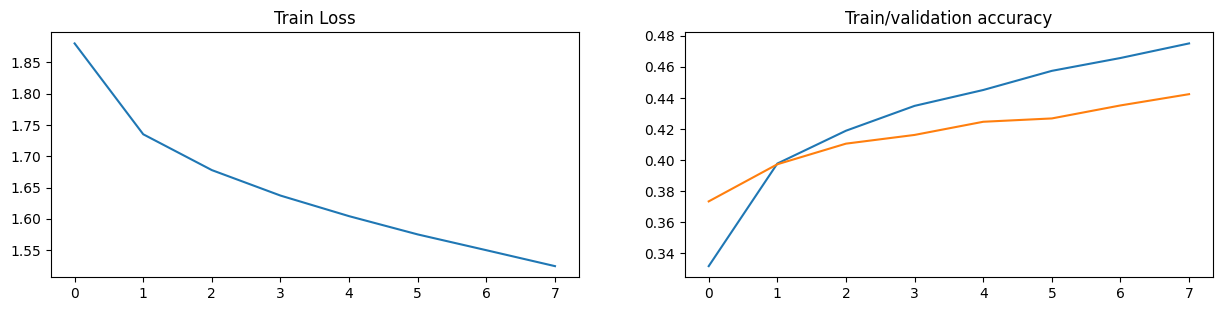

In [11]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title("Train Loss")
plt.plot(history.history['loss'])
plt.subplot(222)
plt.title("Train/validation accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

## Подбор архитектуры собственной сети и гиперпараметров обучения
Как видно из графиков, модель переобучилась. Поэкспериментируйте с гиперпараметрами и архитектурой, чтобы получить точность на тесте больше 80%

In [ ]:
# Experiment here!
class YourNameNet(models.Sequential):
    def __init__(self, input_shape, nb_classes):
        super().__init__()

        self.add(layers.Flatten())
        self.add(layers.Dense(84))
        self.add(layers.Dense(nb_classes, activation='softmax'))    

your_net = YourNameNet(IMAGE_SHAPE, NUM_CLASSES)

In [ ]:
def multiclass_accuracy(y_pred, y_true):
  return np.mean(np.equal(y_true, np.argmax(y_pred, axis=1)))


y_test_pred = lenet.predict(X_test)
test_accuracy = multiclass_accuracy(test_pred, y_test)

print('YourNet test set accuracy: %f' % (test_accuracy, ))
assert test_accuracy > 0.8

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


NameError: name 'test_pred' is not defined

In [ ]:
lenet.save('yournet_cifar10.h5')  